# Plot_delays
Yuqi / Nov 3rd


## Task

Reused the code from [meas-visualization](https://github.com/gourav-prateek-sharma/meas-visualization)

decomposition refers to [Project Course 2024 - Meetings - October 30](https://kth-my.sharepoint.com/personal/gpsharma_ug_kth_se/_layouts/15/Doc.aspx?sourcedoc={d9e5757b-d71d-4ba1-be3b-ad1e7413de21}&action=edit&wd=target%28Meetings.one%7C8619e93e-7501-4f62-a2bf-aac9935e95db%2FOctober%2030%7C4564ea11-ed8e-48dc-8fa7-d040422f0173%2F%29&wdorigin=NavigationUrl)

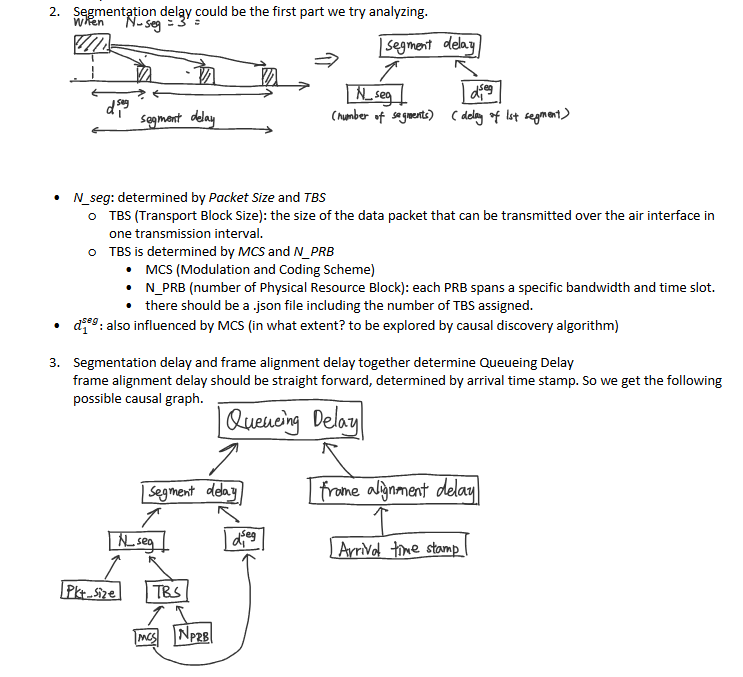


n_segments
ptk_size
prbs_num

if 

## Results

In [7]:
#MEAS_DIR = '../S1-meas/'
MEAS_LABELS = ['s39','s40']
LABELS = ['s39','s40']
#MEAS_LABELS = ['s32', 's33', 's34']
#LABELS = ['s32', 's33', 's34']

In [8]:
from plot_helpers import *
from data_helpers import *
from decomp import *
from sortedcontainers import SortedList, SortedDict
from loguru import logger
import os, sys, gzip, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import JSON

from pathlib import Path

In [9]:
# Initialize lists or dictionaries to store results from each file
packets_list = []
sched_sorted_dicts = []
bsrupd_sorted_dicts = []
sr_bsr_tx_sorted_lists = []
mcs_data = []
mcs_dicts = []
tb_data = []
delays_data = []  # New list to store delays for each file

# Loop through each label and perform the analysis
for MEAS_LABEL in MEAS_LABELS:
    DATA_DIR = './data/' + MEAS_LABEL + '/'
    print(f'reading from json in {DATA_DIR}')
    packets = read_json(DATA_DIR+'packets.json')
    packets_list.append(packets)

    sr_tx_arr = read_json(DATA_DIR+'sr_tx.json')
    bsr_tx_arr = read_json(DATA_DIR+'bsr_tx.json')
    #bsrupd_arr = read_json(DATA_DIR+'bsr_upd.json')
    #bsrupd_sorted_dict = SortedDict({bsrupd['timestamp']: bsrupd for bsrupd in bsrupd_arr})
    #bsrupd_sorted_dicts.append(bsrupd_sorted_dict)

    #bsrupd_sorted_dict = SortedDict({bsrupd['timestamp']: bsrupd for bsrupd in bsrupd_arr})
    sr_bsr_tx_sorted_list = SortedList([sr_tx['timestamp'] for sr_tx in sr_tx_arr]+[bsr_tx['timestamp'] for bsr_tx in bsr_tx_arr])
    sr_bsr_tx_sorted_lists.append(sr_bsr_tx_sorted_list)

    sched_arr = read_json(DATA_DIR+'sched.json')
    sched_sorted_dict = SortedDict({sched['decision_ts']: sched for sched in sched_arr})
    sched_sorted_dicts.append(sched_sorted_dict)
    mcs_arr = read_json(DATA_DIR+'mcs.json')
    #tb_arr = read_json(DATA_DIR+'tb.json')
    mcs_data.append(mcs_arr)
    mcs_dict = SortedDict({mcs['timestamp']: mcs for mcs in mcs_arr})
    mcs_dicts.append(mcs_dict)
    #tb_data.append(tb_arr)
    
    # Delays Calculation
    # send_ts = analyzer.nlmt_df['timestamps.client.send.wall'].to_numpy() / 1e6
    # receive_ts = analyzer.nlmt_df['timestamps.server.receive.wall'].to_numpy() / 1e6
    # idt = send_ts[1:-1] - send_ts[0:-2]
    # e2e_delays = receive_ts - send_ts
    
    # Frame alignment delays
    frame_alignment_delays = np.array(list({packet['id']: get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) 
    for packet in packets 
        if get_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # Scheduling delays
    scheduling_delays = np.array(list({packet['id']: get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) 
    for packet in packets 
        if get_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # RAN delays
    ran_delays = np.array(list({packet['id']: get_ran_delay(packet) 
    for packet in packets 
        if get_ran_delay(packet) is not None}.values()))
    
    # RAN delays without frame alignment
    ran_delays_wo_frame_alignment_delay = np.array(list({packet['id']: get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) 
    for packet in packets 
        if get_ran_delay_wo_frame_alignment_delay(packet, sr_bsr_tx_sorted_list, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # RAN delays without scheduling delay
    ran_delays_wo_scheduling_delay = np.array(list({packet['id']: get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) 
    for packet in packets 
        if get_ran_delay_wo_scheduling_delay(packet, sched_sorted_dict, slots_per_frame=20, slots_duration_ms=0.5) is not None}.values()))
    
    # Queueing delays
    queueing_delays = np.array(list({packet['id']: get_queueing_delay(packet) 
    for packet in packets 
        if get_queueing_delay(packet) is not None}.values()))
    
    # Retransmission delays
    retx_delays = np.array(list({packet['id']: get_retx_delay(packet) 
    for packet in packets 
        if get_retx_delay(packet) is not None}.values()))
    
    # Segmentation delays
    segmentation_delays = np.array(list({packet['id']: get_segmentation_delay(packet) 
    for packet in packets 
        if get_segmentation_delay(packet) is not None}.values()))

    # segments
    segments = np.array(list({packet['id']: get_segments(packet) for packet in packets if get_segments(packet) is not None}.values()))
    

    # mcs 
    mcs = np.array(list({packet['id']: get_mcs(packet, mcs_dict) for packet in packets if get_mcs(packet, mcs_dict) is not None}.values()))
    
    # Collect all delays in a dictionary for this file
    delays_data.append({
        #'e2e_delays': e2e_delays,
        'frame_alignment_delays': frame_alignment_delays,
        'scheduling_delays': scheduling_delays,
        'ran_delays': ran_delays,
        'ran_delays_wo_frame_alignment_delay': ran_delays_wo_frame_alignment_delay,
        'ran_delays_wo_scheduling_delay': ran_delays_wo_scheduling_delay,
        'queueing_delays': queueing_delays,
        'retx_delays': retx_delays,
        'segmentation_delays': segmentation_delays,
        'segments': segments,
        'mcs': mcs,
    })

# Now you have the data from all files stored in packets_list, sched_sorted_dicts, sr_bsr_tx_sorted_lists, mcs_data, tb_data, and delays_data

reading from json in ./data/s39/
2024-11-04 15:10:48.907 | ERROR    | decomp:get_tx_delay:144 - Packet 16138 phy.in_t or phy.in_t not present
2024-11-04 15:10:48.910 | ERROR    | decomp:get_tx_delay:144 - Packet 16138 phy.in_t or phy.in_t not present
2024-11-04 15:10:49.515 | ERROR    | decomp:get_tx_delay:144 - Packet 10013 phy.in_t or phy.in_t not present
2024-11-04 15:10:49.517 | ERROR    | decomp:get_tx_delay:144 - Packet 10013 phy.in_t or phy.in_t not present
reading from json in ./data/s40/


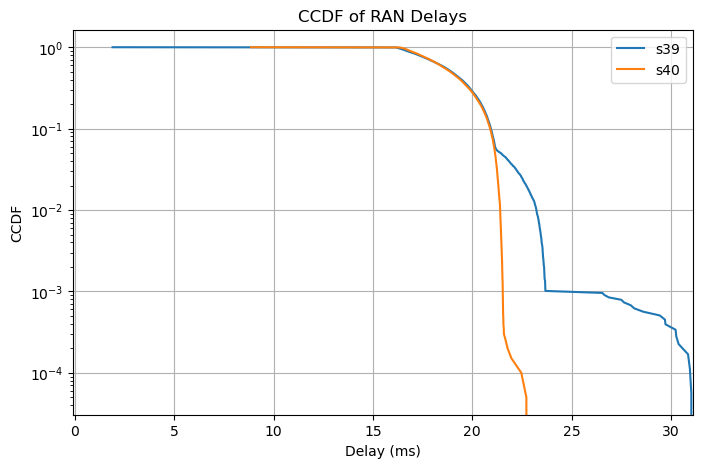

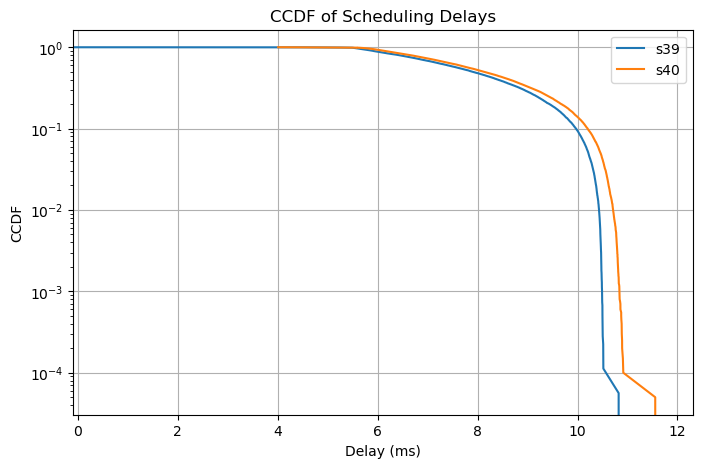

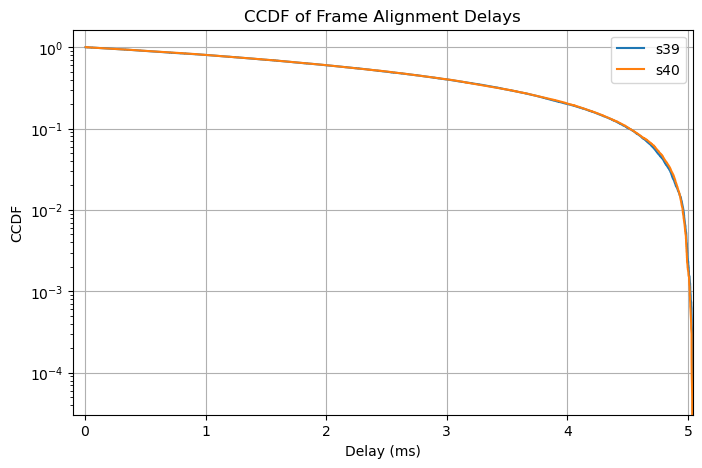

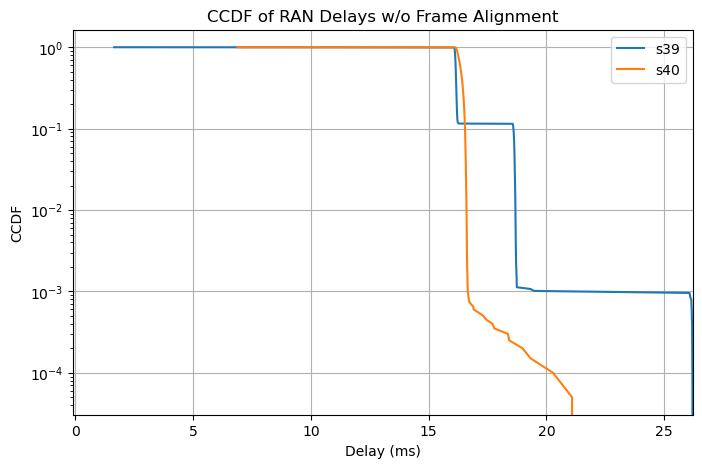

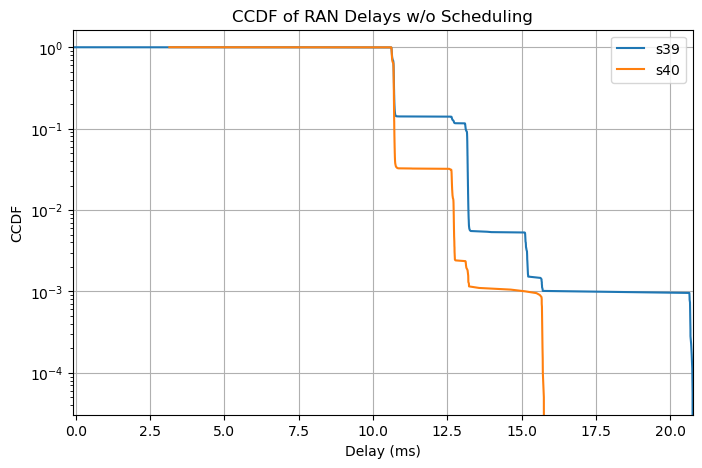

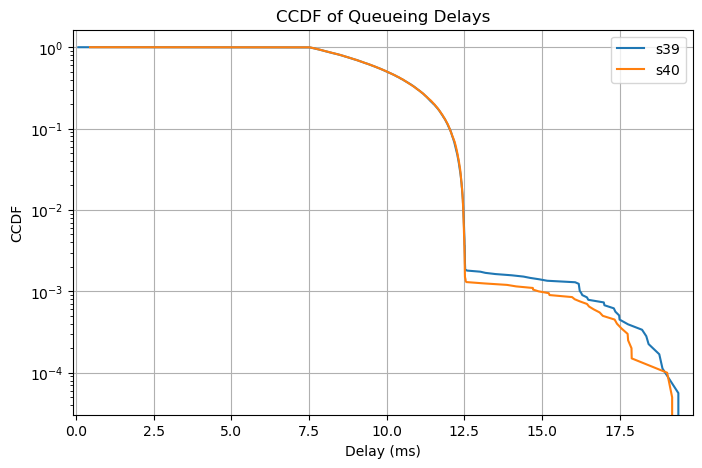

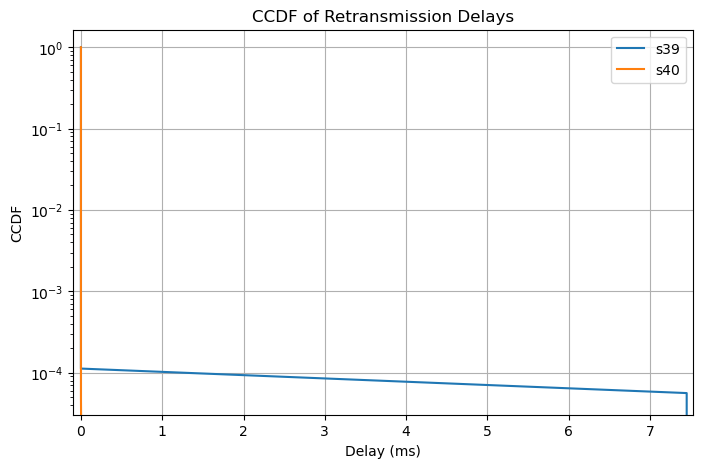

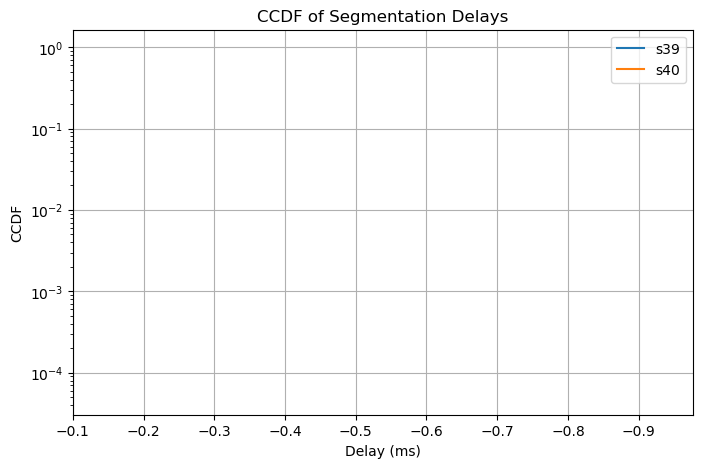

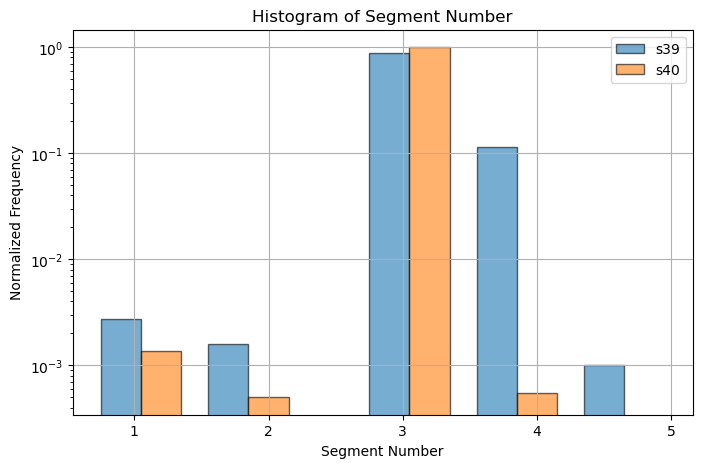

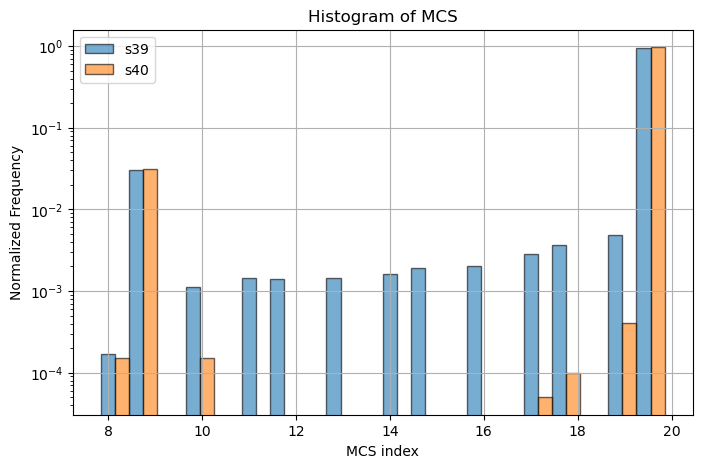

In [10]:
# Ensure the PLOTS_DIR exists
PLOTS_DIR = "./plots/"+"_".join(MEAS_LABELS)
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

# Skip constants
SKIP_FIRST = 1000
SKIP_LAST = 3000

# Initialize lists to store delay data from all DB files for each delay type
e2e_delays_per_db = []
ran_delays_per_db = []
scheduling_delays_per_db = []
frame_alignment_delays_per_db = []
ran_delays_wo_frame_alignment_delay_per_db = []
ran_delays_wo_scheduling_delay_per_db = []
queueing_delays_per_db = []
retx_delays_per_db = []
segmentation_delays_per_db = []
mcs_per_db = []
segments_per_db = []

# Collect delay data from each DB file
for idx, delays in enumerate(delays_data):
    #e2e_delays_per_db.append(delays['e2e_delays'][SKIP_FIRST:-SKIP_LAST])
    ran_delays_per_db.append(delays['ran_delays'][SKIP_FIRST:-SKIP_LAST])
    scheduling_delays_per_db.append(delays['scheduling_delays'][SKIP_FIRST:-SKIP_LAST])
    frame_alignment_delays_per_db.append(delays['frame_alignment_delays'][SKIP_FIRST:-SKIP_LAST])
    ran_delays_wo_frame_alignment_delay_per_db.append(delays['ran_delays_wo_frame_alignment_delay'][SKIP_FIRST:-SKIP_LAST])
    ran_delays_wo_scheduling_delay_per_db.append(delays['ran_delays_wo_scheduling_delay'][SKIP_FIRST:-SKIP_LAST])
    queueing_delays_per_db.append(delays['queueing_delays'][SKIP_FIRST:-SKIP_LAST])
    retx_delays_per_db.append(delays['retx_delays'][SKIP_FIRST:-SKIP_LAST])
    segmentation_delays_per_db.append(delays['segmentation_delays'][SKIP_FIRST:-SKIP_LAST])
    mcs_per_db.append(delays['mcs'][SKIP_FIRST:-SKIP_LAST])
    segments_per_db.append(delays['segments'][SKIP_FIRST:-SKIP_LAST])


# Plot E2E Delays for all DB files on the same axis
# fig, ax = plt.subplots(figsize=(8, 5))
# plot_multiple_ccdf_per_delay_type(e2e_delays_per_db, 'E2E Delays', ax, labels=LABELS)
# plt.savefig(f"{PLOTS_DIR}e2e_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
# plt.show()

# Plot RAN Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(ran_delays_per_db, 'RAN Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}ran_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Scheduling Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(scheduling_delays_per_db, 'Scheduling Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}scheduling_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Frame Alignment Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(frame_alignment_delays_per_db, 'Frame Alignment Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}frame_alignment_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot RAN Delays w/o Frame Alignment for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(ran_delays_wo_frame_alignment_delay_per_db, 'RAN Delays w/o Frame Alignment', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_frame_alignment_delay_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot RAN Delays w/o Scheduling for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(ran_delays_wo_scheduling_delay_per_db, 'RAN Delays w/o Scheduling', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}ran_delays_wo_scheduling_delay_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Queueing Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(queueing_delays_per_db, 'Queueing Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}queueing_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Retransmission Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(retx_delays_per_db, 'Retransmission Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}retx_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Segmentation Delays for all DB files on the same axis
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_ccdf_per_delay_type(segmentation_delays_per_db, 'Segmentation Delays', ax, labels=LABELS)
plt.savefig(f"{PLOTS_DIR}segmentation_delays_combined_ccdf_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# plot segments histograms
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_histograms(segments_per_db, ax, labels=LABELS, y_log=True, bins=10, outlier=None, xlabel="Segment Number", title="Histogram of Segment Number")
plt.savefig(f"{PLOTS_DIR}segments_hist_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# plot mcs histograms
fig, ax = plt.subplots(figsize=(8, 5))
plot_multiple_histograms(mcs_per_db, ax, labels=LABELS, y_log=True, bins=20, outlier=None, xlabel="MCS index", title="Histogram of MCS")
plt.savefig(f"{PLOTS_DIR}mcs_hist_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
print(segmentation_delays_per_db)
print(np.sum(segmentation_delays_per_db[1]>=0))

[array([-1.06072259, -1.07457733, -1.04687405, ..., -1.08021688,
       -1.12824059, -1.09968042]), array([-1.10181093, -1.11927271, -1.09413147, ..., -1.48870254,
       -1.47825527, -1.49899483])]
0


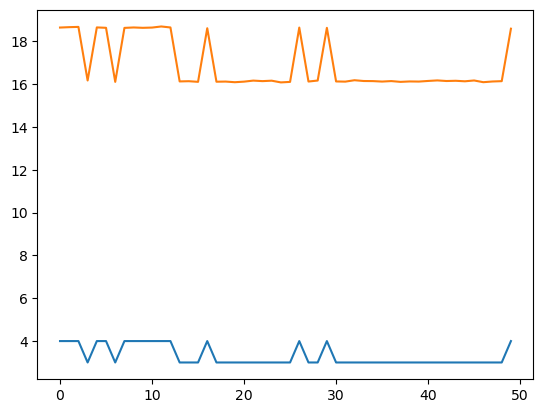

In [12]:
plt.plot(segments_per_db[0][3000:3050])
plt.plot(ran_delays_wo_frame_alignment_delay_per_db[0][3000:3050])
#plt.plot([packet['len'] for packet in packets_list[0][3000:3050]])
print()

________________________

- Some Acronym:
    - so:       segment offset
    - sn:       serial number
        

    - rlc:      radio link control
    - sr:       scheduling request
    - bsr:      buffer status report
    - mcs:      modulation and coding scheme
    - sched:    scheduling